In [1]:
%load_ext autoreload
%autoreload 2

In [14]:
import matplotlib.pyplot as plt
import mplfinance as mplf
import numpy as np
import pandas as pd

import bars
import u
import c

# Data Generation

<AxesSubplot:>

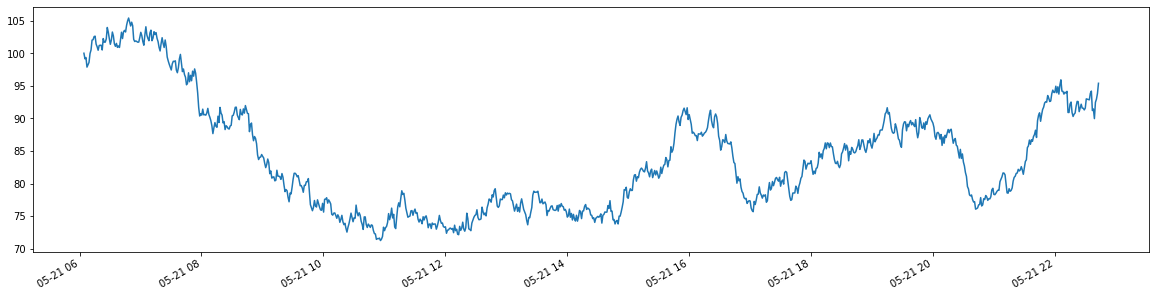

In [3]:
plt.rcParams["figure.figsize"] = (20, 5)

data = u.create_price_data(theta=0.0001, start_price=100, n_samples=1000)
data["close"].plot.line()

# Triple Barrier

In [4]:
def _price_target_stop_loss_indices(prices: pd.Series, target: float, side = c.Dir.B, price_target = None, stop_loss = None):
    if side == c.Dir.S:
        price_target, stop_loss = stop_loss, price_target

    upper_idx = None
    lower_idx = None

    if price_target is not None:
        upper_target = prices[0] * (1 + target * price_target)
        for i, p in prices.iteritems():
            if p >= upper_target:
                upper_idx = i
                break

    if stop_loss is not None:
        lower_target = prices[0] * (1 - target * stop_loss)
        for i, p in prices.iteritems():
            if p <= lower_target:
                lower_idx = i
                break
                
    if side == c.Dir.S:
        return (lower_idx, upper_idx)
    
    return (upper_idx, lower_idx)

In [31]:
from matplotlib.patches import Rectangle

def plot_triple_barrier(ax, market_data, barriers, start_dt, target, side = c.Dir.B, price_target=None, stop_loss=None, vertical_barrier=None):
    if side == c.Dir.S:
        price_target, stop_loss = stop_loss, price_target

    initial_price = market_data.at[start_dt, "close"]
    price_target_dt = barriers.at[start_dt, "pt_dt"] 
    stop_loss_dt = barriers.at[start_dt, "sl_dt"]
    
    width = market_data.index[-1] - start_dt if vertical_barrier is None else vertical_barrier

    upper_color =("g" if side == c.Dir.B else "r")
    lower_color =("r" if side == c.Dir.B else "g")
    if price_target is not None:
        upper_target = initial_price * (1 + target * price_target)
        rect = Rectangle((start_dt, market_data.at[start_dt, "close"]), width, upper_target - initial_price, linestyle = 'dashed', facecolor = 'None', edgecolor=upper_color)
        ax.add_patch(rect)
    if stop_loss is not None:
        lower_target = initial_price * (1 - target * stop_loss)
        rect = Rectangle((start_dt, market_data.at[start_dt, "close"]), width, lower_target - initial_price, linestyle = 'dashed', facecolor = 'None', edgecolor=lower_color)
        ax.add_patch(rect)
    if price_target_dt is not None:
        ax.plot(price_target_dt, market_data.at[price_target_dt, "close"], color=upper_color, marker='o')
    if stop_loss_dt is not None:
        ax.plot(stop_loss_dt, market_data.at[stop_loss_dt, "close"], color=lower_color, marker='o')

In [25]:
from matplotlib.patches import Rectangle

u, l = _price_target_stop_loss_indices(data["close"], target=0.05, price_target=1, stop_loss=2)

barriers = pd.DataFrame(columns=["pt_dt", "sl_dt"])
barriers.loc[data.index[0]] = pd.Series(data={"pt_dt": u, "sl_dt": l}, name=data.index[0])
barriers

,pt_dt,sl_dt
2022-05-21 06:04:17.873402,2022-05-21 06:48:17.873402,2022-05-21 08:09:17.873402


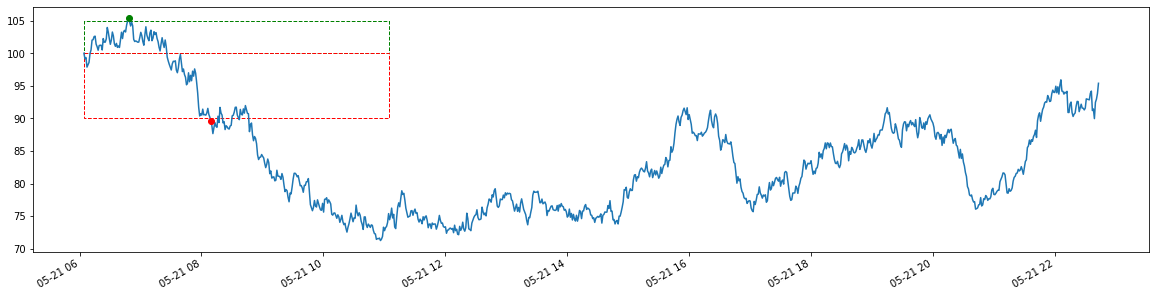

In [33]:
fig, ax = plt.subplots()
data["close"].plot.line()

plot_triple_barrier(ax, data, barriers, data.index[0], target=0.05, price_target=1, stop_loss=2, vertical_barrier=np.timedelta64(5, "h"))